[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14uE_vjLnjHH54S--Fb4Csey4nbsk0WqP?usp=sharing)

# Object detection

Ref: https://huggingface.co/docs/datasets/object_detection

Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output
coordinates of the bounding boxes and associated labels of the detected objects. An image can contain multiple objects,
each with its own bounding box and a label (e.g. it can have a car and a building), and each object can
be present in different parts of an image (e.g. the image can have several cars).
This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights.
Other applications include counting objects in images, image search, and more.

In this guide, you will learn how to:

 1. Finetune [DETR](https://huggingface.co/docs/transformers/model_doc/detr), a model that combines a convolutional
 backbone with an encoder-decoder Transformer, on the [CPPE-5](https://huggingface.co/datasets/cppe-5)
 dataset.
 2. Use your finetuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[Conditional DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/conditional_detr), [Deformable DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/deformable_detr), [DETA](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/deta), [DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/detr), [Table Transformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/table-transformer), [YOLOS](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/yolos)

<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q datasets transformers evaluate timm albumentations
```

You'll use 🤗 Datasets to load a dataset from the Hugging Face Hub, 🤗 Transformers to train your model,
and `albumentations` to augment the data. `timm` is currently required to load a convolutional backbone for the DETR model.

We encourage you to share your model with the community. Log in to your Hugging Face account to upload it to the Hub.
When prompted, enter your token to log in:

In [ ]:
# Transformers installation
! pip install -q -U transformers datasets timm accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load the CPPE-5 dataset

The [CPPE-5 dataset](https://huggingface.co/datasets/cppe-5) contains images with
annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.

Start by loading the dataset:

In [ ]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")
cppe5

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

You'll see that this dataset already comes with a training set containing 1000 images and a test set with 29 images.

To get familiar with the data, explore what the examples look like.

In [ ]:
cppe5["train"][0]

{'image_id': 15,
 'image': <PIL.Image.Image image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

The examples in the dataset have the following fields:
- `image_id`: the example image id
- `image`: a `PIL.Image.Image` object containing the image
- `width`: width of the image
- `height`: height of the image
- `objects`: a dictionary containing bounding box metadata for the objects in the image:
  - `id`: the annotation id
  - `area`: the area of the bounding box
  - `bbox`: the object's bounding box (in the [COCO format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco) )
  - `category`: the object's category, with possible values including `Coverall (0)`, `Face_Shield (1)`, `Gloves (2)`, `Goggles (3)` and `Mask (4)`

You may notice that the `bbox` field follows the COCO format, which is the format that the DETR model expects.
However, the grouping of the fields inside `objects` differs from the annotation format DETR requires. You will
need to apply some preprocessing transformations before using this data for training.

To get an even better understanding of the data, visualize an example in the dataset.

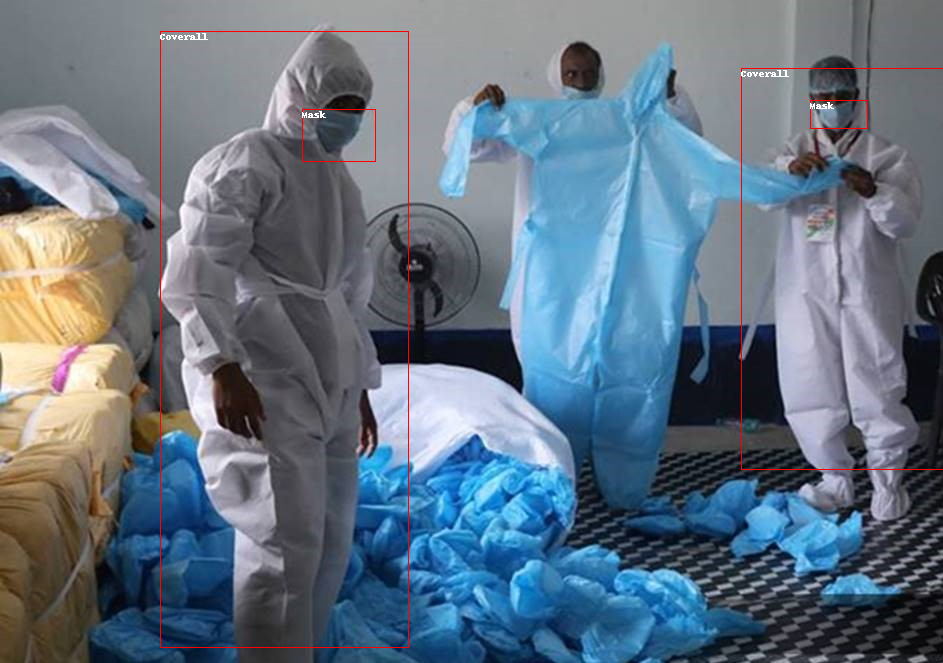

In [ ]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][0]["image"]
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

<div class="flex justify-center">
    <img src="https://i.imgur.com/TdaqPJO.png" alt="CPPE-5 Image Example"/>
</div>

To visualize the bounding boxes with associated labels, you can get the labels from the dataset's metadata, specifically
the `category` field.
You'll also want to create dictionaries that map a label id to a label class (`id2label`) and the other way around (`label2id`).
You can use them later when setting up the model. Including these maps will make your model reusable by others if you share
it on the Hugging Face Hub.

As a final step of getting familiar with the data, explore it for potential issues. One common problem with datasets for
object detection is bounding boxes that "stretch" beyond the edge of the image. Such "runaway" bounding boxes can raise
errors during training and should be addressed at this stage. There are a few examples with this issue in this dataset.
To keep things simple in this guide, we remove these images from the data.

In [ ]:
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx]
cppe5["train"] = cppe5["train"].select(keep)

## Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model.
[AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and
`labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial
to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Before passing the images to the `image_processor`, apply two preprocessing transformations to the dataset:
- Augmenting images
- Reformatting annotations to meet DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/) ...
This library ensures that transformations affect the image and update the bounding boxes accordingly.
The 🤗 Datasets library documentation has a detailed [guide on how to augment images for object detection](https://huggingface.co/docs/datasets/object_detection),
and it uses the exact same dataset as an example. Apply the same approach here, resize each image to (480, 480),
flip it horizontally, and brighten it:

In [ ]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

The `image_processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`,
 where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [ ]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

Now you can combine the image and annotation transformations to use on a batch of examples:

In [ ]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

Apply this preprocessing function to the entire dataset using 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform) method. This method applies
transformations on the fly when you load an element of the dataset.

At this point, you can check what an example from the dataset looks like after the transformations. You should see a tensor
with `pixel_values`, a tensor with `pixel_mask`, and `labels`.

In [ ]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)
cppe5["train"][15]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[ 1.7180,  1.7180,  1.7180,  ..., -1.4158, -1.4158, -1.4158],
          [ 1.7180,  1.7180,  1.7180,  ..., -1.4158, -1.4158, -1.4158],
          [ 1.7180,  1.7180,  1.7180,  ..., -1.3987, -1.3987, -1.3987],
          ...,
          [-0.9705, -0.9705, -0.9705,  ..., -1.4329, -1.4329, -1.4329],
          [-0.9534, -0.9534, -0.9534,  ..., -1.4329, -1.4158, -1.4158],
          [-0.9534, -0.9534, -0.9534,  ..., -1.4329, -1.4158, -1.4158]],
 
         [[ 2.1485,  2.1485,  2.1485,  ..., -1.2654, -1.2654, -1.2654],
          [ 2.1485,  2.1485,  2.1485,  ..., -1.2654, -1.2654, -1.2654],
          [ 2.1485,  2.1485,  2.1485,  ..., -1.2479, -1.2479, -1.2479],
          ...,
          [-0.6877, -0.6877, -0.6877,  ..., -1.2829, -1.2829, -1.2829],
          [-0.6702, -0.6702, -0.6702,  ..., -1.2829, -1.2654, -1.2654],
          [-0.6702, -0.6702, -0.6702,  ..., -1.2829, -1.2654, -1.2654]],
 
         [[ 2.2566,  2.2566,  2.2566,  ..., -1.0724, -1.0724, -1.0724],
          [ 

You have successfully augmented the individual images and prepared their annotations. However, preprocessing isn't
complete yet. In the final step, create a custom `collate_fn` to batch images together.
Pad images (which are now `pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask`
to indicate which pixels are real (1) and which are padding (0).

In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Training the DETR model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model!
The images in this dataset are still quite large, even after resizing. This means that finetuning this model will
require at least one GPU.

Training involves the following steps:
1. Load the model with [AutoModelForObjectDetection](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
2. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
3. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
4. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id`
and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In the [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit.
It is important you do not remove unused columns because this will drop the image column. Without the image column, you
can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
If you wish to share your model by pushing to the Hub, set `push_to_hub` to `True` (you must be signed in to Hugging
Face to upload your model).

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=30,
    fp16=False,
    save_steps=200,
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=1e-4,
    greater_is_better=True,
    # load_best_model_at_end=True,
    save_total_limit=2,
    # eval_strategy="epoch",
    # save_strategy="epoch",
    remove_unused_columns=False,
    push_to_hub=True,
)

Finally, bring everything together, and call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

trainer.train()

Step,Training Loss
50,2.715600
100,2.455300
150,2.290900
200,2.189900
250,2.140300


Step,Training Loss
50,2.715600
100,2.455300
150,2.290900
200,2.189900
250,2.140300
300,2.102300
350,2.042400
400,2.020000
450,1.908300
500,1.929600


TrainOutput(global_step=3750, training_loss=1.448632255045573, metrics={'train_runtime': 7320.8749, 'train_samples_per_second': 4.069, 'train_steps_per_second': 0.512, 'total_flos': 1.42341326915328e+19, 'train_loss': 1.448632255045573, 'epoch': 30.0})

If you have set `push_to_hub` to `True` in the `training_args`, the training checkpoints are pushed to the
Hugging Face Hub. Upon training completion, push the final model to the Hub as well by calling the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method.

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/aromo17/detr-resnet-50_finetuned_cppe5/commit/f3863eb5fd2131b16b2cfe8ea229957770af404b', commit_message='End of training', commit_description='', oid='f3863eb5fd2131b16b2cfe8ea229957770af404b', pr_url=None, pr_revision=None, pr_num=None)

## Inference

Now that you have finetuned a DETR model, evaluated it, and uploaded it to the Hugging Face Hub, you can use it for inference.
The simplest way to try out your finetuned model for inference is to use it in a [Pipeline](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.Pipeline). Instantiate a pipeline
for object detection with your model, and pass an image to it:

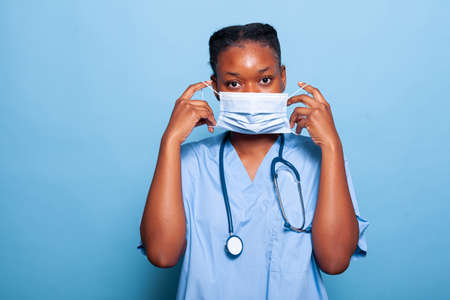

In [ ]:
from PIL import Image, ImageDraw
from transformers import pipeline
import urllib.request

url = 'https://us.123rf.com/450wm/dragoscondrea/dragoscondrea2111/dragoscondrea211101047/179851457-enfermera-practicante-afroamericana-que-pone-mascarilla-protectora-para-prevenir-la-infecci%C3%B3n-por.jpg?ver=6'
urllib.request.urlretrieve(url, "sample.jpg")
image = Image.open("sample.jpg")

image

In [ ]:
obj_detector_finetuned = pipeline("object-detection", model="aromo17/detr-resnet-50_finetuned_cppe5")
obj_detector_baseline = pipeline("object-detection", model=checkpoint)

results_finetuned = obj_detector_finetuned(image)
results_baseline = obj_detector_baseline(image)

print("results baseline \n", results_baseline)
print("results finetuned \n", results_finetuned)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


results baseline 
 [{'score': 0.9993126392364502, 'label': 'person', 'box': {'xmin': 138, 'ymin': 21, 'xmax': 365, 'ymax': 297}}]
results finetuned 
 [{'score': 0.7020894289016724, 'label': 'Mask', 'box': {'xmin': 209, 'ymin': 88, 'xmax': 284, 'ymax': 131}}, {'score': 0.8105437159538269, 'label': 'Coverall', 'box': {'xmin': 136, 'ymin': 82, 'xmax': 352, 'ymax': 298}}]


Let's plot the result:

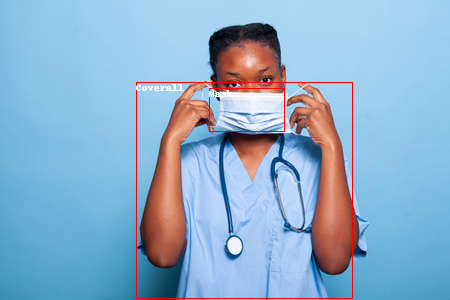

In [ ]:
score_theshold = 0.5
draw = ImageDraw.Draw(image)

for obj in results_finetuned:
    score = obj["score"]

    if score >= score_theshold:
        label = obj["label"]
        box_dict = obj["box"]
        box = [round(i, 2) for i in list(box_dict.values())]
        x, y, x2, y2 = tuple(box)
        draw.rectangle((x, y, x2, y2), outline="red", width=1)
        draw.text((x, y), label, fill="white")

image